In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1PZlMKqtQ1vlURqGx0NBtoQ8yb2RTjuAy'}) # replace the id with id of file you want to access
downloaded.GetContentFile('oasis_longitudinal.csv') 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#DataSet load
df = pd.read_csv('oasis_longitudinal.csv')


In [ ]:
#prepossessing
df = df.loc[df['Visit']==1]
df = df.reset_index(drop=True)
df['M/F'] = df['M/F'].replace(['F','M'], [0,1])
df['Group'] = df['Group'].replace(['Demented', 'Nondemented','Converted'], [1,0,1])
df.head()
df = df.drop(['Subject ID','MRI ID','Hand', 'Visit'], axis=1)
df[df==np.inf]=np.nan
df.fillna(df.mean(), inplace=True)

x = df.iloc[:,1:11]  #independent columns

y = df.iloc[:,0]  #target coloum

   Name      value
6   CDR  36.000000
5  MMSE  12.850211
1   M/F   3.891232
3  EDUC   3.821454
7  eTIV   1.116436
4   SES   0.323267
8  nWBV   0.019006
2   Age   0.000476
9   ASF   0.000247
Heatmap of Features 


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


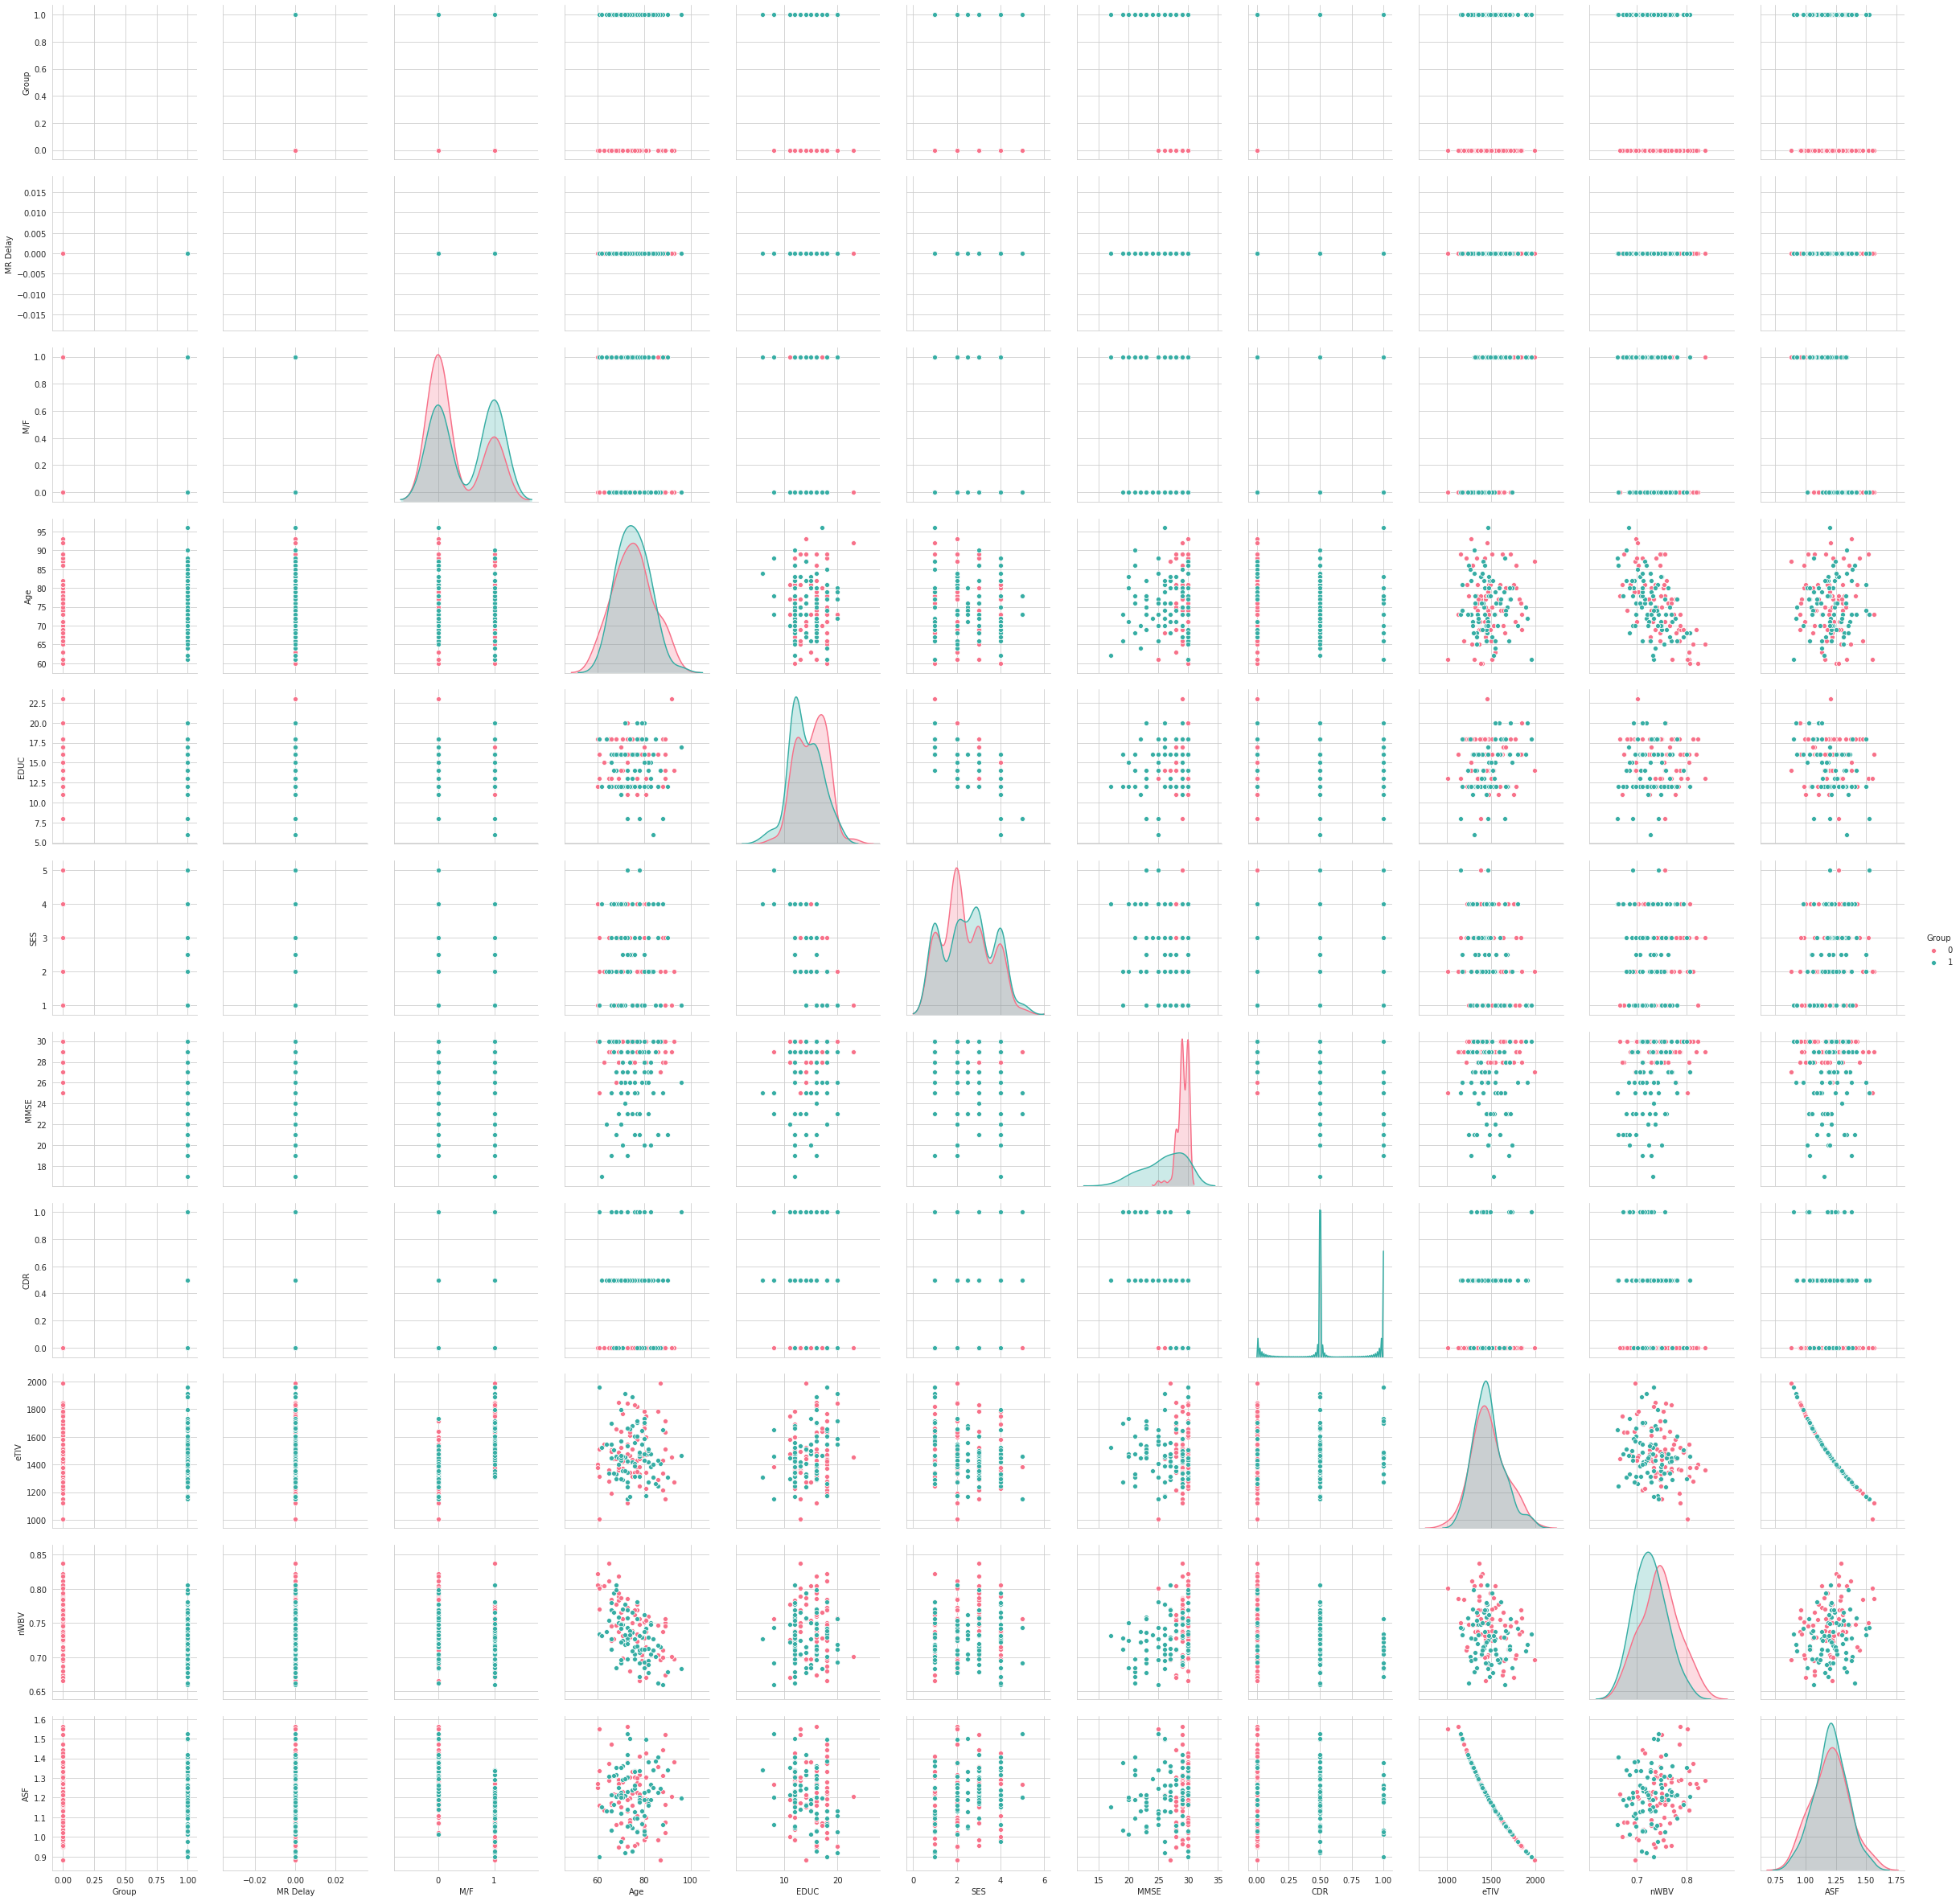

In [ ]:
#Feature 
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Name','value']  #naming the dataframe columns
print(featureScores.nlargest(11,'value'))  #print 11 best features
print("Heatmap of Features ")
plt.close();
sns.set_style("whitegrid");
sns.pairplot(df, hue="Group", palette="husl", height=3);
plt.show()

In [ ]:
#SVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc, classification_report



In [ ]:
#Split
X_trainval, X_test, Y_trainval, Y_test = train_test_split(x, y,test_size=0.30,random_state=321)

#Feature Scaling
scaler = MinMaxScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Model

best_score = 0
kfolds=5
acc = []
c_c=list(np.arange(0.00001,10,0.5))
g_g=list(np.arange(0.001,12,0.5))
for k_parameter in ['rbf', 'linear', 'poly', 'sigmoid']:
    for c_paramter in c_c:
        for gamma_paramter in g_g:
         
             svmModel = SVC(kernel=k_parameter, C=c_paramter, gamma=gamma_paramter)
             scores = cross_val_score(svmModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
             score = np.mean(scores)
             
             if score > best_score:
                best_score = score
                best_parameter_c = c_paramter
                best_parameter_gamma = gamma_paramter
                best_parameter_k = k_parameter
    
SelectedSVMmodel = SVC(C=best_parameter_c, gamma=best_parameter_gamma, kernel=best_parameter_k).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedSVMmodel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedSVMmodel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("HyperParameter Tuning Results")
print("Best accuracy on cross validation set is:", best_score)
print("Best parameter for c is: ", best_parameter_c)
print("Best parameter for gamma is: ", best_parameter_gamma)
print("Best parameter for kernel is: ", best_parameter_k)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is", test_recall)
print("Test AUC with the best parameter is", test_auc)
m = 'SVM'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

#Confusion matrix
ccm = confusion_matrix(Y_test,PredictedOutput) 
print ('Confusion Matrix :')
print(ccm) 
print ('Accuracy Score :',accuracy_score(Y_test,PredictedOutput))
print ('Report : ')
print (classification_report(Y_test,PredictedOutput))

HyperParameter Tuning Results
Best accuracy on cross validation set is: 0.9142857142857143
Best parameter for c is:  7.000009999999999
Best parameter for gamma is:  1.001
Best parameter for kernel is:  sigmoid
Test accuracy with the best parameters is 0.8666666666666667
Test recall with the best parameters is 0.8260869565217391
Test AUC with the best parameter is 0.8675889328063241
Confusion Matrix :
[[20  2]
 [ 4 19]]
Accuracy Score : 0.8666666666666667
Report : 
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        22
           1       0.90      0.83      0.86        23

    accuracy                           0.87        45
   macro avg       0.87      0.87      0.87        45
weighted avg       0.87      0.87      0.87        45



In [ ]:
### MLP

Y_train_n = Y_trainval
Y_test_n  = Y_test

X_train_n = X_trainval_scaled 
X_test_n  = X_test_scaled 


In [ ]:
!pip install -q keras
import keras
from keras.models import Sequential
from keras import layers 
from keras.layers import Dense, Dropout
from keras.optimizers import Adam,sgd


In [ ]:
# init NN

pp=Sequential()

#Adding input layer and first hidden layer 
pp.add(layers.Dense(output_dim = 13, init ='uniform', activation ='relu', input_dim=10))
pp.add(Dropout(0.5))

# adding second hidden layer 
pp.add(layers.Dense(output_dim = 18, init='uniform', activation ='relu'))
pp.add(Dropout(0.5))

pp.add(layers.Dense(output_dim = 5, init='uniform', activation ='relu'))
pp.add(Dropout(0.5))
# adding output layer 
pp.add(layers.Dense(output_dim = 1, init='uniform', activation='relu'))

 	






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=10, units=13, kernel_initializer="uniform")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=18, kernel_initializer="uniform")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=5, kernel_initializer="uniform")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=1, kernel_initializer="uniform")`
  from ipykernel import kernelapp as app


In [ ]:
#compling the nn
pp.compile(Adam(lr=0.01), loss='binary_crossentropy', metrics =['accuracy'])


# fitting the model
y=pp.fit(X_train_n,Y_train_n,batch_size = 10, nb_epoch =500)

#predicting the test set result
y_pred=pp.predict(X_test_n)
y_pred=(y_pred >0.5)


print(pp.summary())




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """





Epoch 1/500





105/105 [==============================] - 1s 6ms/step - loss: 2.7043 - acc: 0.4762
Epoch 2/500
105/105 [==============================] - 0s 178us/step - loss: 1.2516 - acc: 0.4762
Epoch 3/500
105/105 [==============================] - 0s 175us/step - loss: 1.3586 - acc: 0.4476
Epoch 4/500
105/105 [==============================] - 0s 159us/step - loss: 1.2192 - acc: 0.5810
Epoch 5/500
105/105 [==============================] - 0s 168us/step - loss: 0.9215 - acc: 0.4762
Epoch 6/500
105/105 [==============================] - 0s 150us/step - loss: 1.1798 - acc: 0.5143
Epoch 7/500
105/105 [==============================] - 0s 165us/step - loss: 0.9011 - acc: 0.5333
Epoch 8/500
105/105 [==============================] - 0s 151us/step - loss: 0.8595 - acc: 0.5048
Epoch 9/500
105/105 [==============================] - 0s 150us/step - loss: 0.8795 - acc: 0.5619
Epoch 10/500
105/105 [==============================] - 0s 170us/step - loss: 1.4336 - acc: 0.6095
Epoch 11/500


In [ ]:
# creating the confusion matrix

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

cm = confusion_matrix(Y_test_n,y_pred) 
print ('Confusion Matrix :')
print(cm) 
print ('Accuracy Score :',accuracy_score(Y_test_n,y_pred))
print ('Report : ')
print (classification_report(Y_test_n,y_pred))

Confusion Matrix :
[[22  0]
 [ 3 20]]
Accuracy Score : 0.9333333333333333
Report : 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        22
           1       1.00      0.87      0.93        23

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



In [ ]:
!apt install libnvrtc8.0
!pip install mxnet-cu80

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'
     |████████████████████████████████| 372.1MB 43kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Accuracy on cross validation using 5 flods : 0.91 (+/- 0.07) [SVM]
Accuracy on cross validation using 5 flods : 0.86 (+/- 0.07) [MLP]
Accuracy on cross validation using 5 flods : 0.90 (+/- 0.06) [Ensemble]
Confusion Matrix For SVM:
[[20  2]
 [ 4 19]]
Accuracy Score : 0.8666666666666667
Report : 
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        22
           1       0.90      0.83      0.86        23

    accuracy                           0.87        45
   macro avg       0.87      0.87      0.87        45
weighted avg       0.87      0.87      0.87        45

Confusion Matrix For MLP:
[[22  0]
 [ 3 20]]
Accuracy Score : 0.9333333333333333
Report : 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        22
           1       1.00      0.87      0.93        23

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg 

Text(0.5, 1, 'Confusion Matrix')

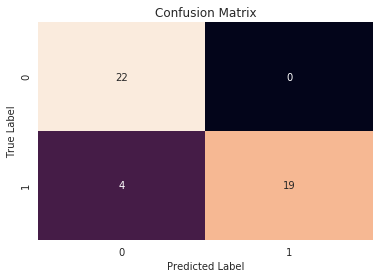

In [ ]:
#Ensemble

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import EnsembleVoteClassifier

X_train_en = X_trainval_scaled
X_test_en  = X_test_scaled 
Y_train_en = Y_trainval
Y_test_en  = Y_test


en_svm = SVC(C=7.000009999999999, gamma= 1.001, kernel='sigmoid')

en_mlp = MLPClassifier(activation='relu',hidden_layer_sizes=(13,18,5), solver='adam',batch_size=10,learning_rate='constant',learning_rate_init=0.01, max_iter=500, tol=0.0001 )

# create the ensemble model

eclf = EnsembleVoteClassifier(clfs=[en_svm, en_mlp],voting = 'hard')

labels = ['SVM', 'MLP', 'Ensemble']
for clf, label in zip([en_svm, en_mlp, eclf], labels):

     #validation performance
    scores = cross_val_score(clf, X_train_en, Y_train_en, cv=5, scoring='accuracy')
    
    print("Accuracy on cross validation using 5 flods : %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

#SVM  
En_model_svm = en_svm.fit(X_train_en, Y_train_en)
p_svm = En_model_svm.predict(X_test_en) 
cm_en_svm = confusion_matrix(Y_test_en,p_svm) 
print ('Confusion Matrix For SVM:')
print (cm_en_svm) 
print ('Accuracy Score :',accuracy_score(Y_test_en,p_svm))
print ('Report : ')
print (classification_report(Y_test_en,p_svm))
import seaborn as sns


#MLP  
En_model_mlp = en_mlp.fit(X_train_en, Y_train_en)
p_mlp = En_model_mlp.predict(X_test_en) 
cm_en_mlp = confusion_matrix(Y_test_en,p_mlp) 
print ('Confusion Matrix For MLP:')
print (cm_en_mlp) 
print ('Accuracy Score :',accuracy_score(Y_test_en,p_mlp))
print ('Report : ')
print (classification_report(Y_test_en,p_mlp))


#Ensemble or Proposed model  
En_model_prop = eclf.fit(X_train_en, Y_train_en)
p_prop = En_model_prop.predict(X_test_en) 
cm_en_prop = confusion_matrix(Y_test_en,p_prop) 
print ('Confusion Matrix For Proposed Model:')
print (cm_en_prop) 
print ('Accuracy Score :',accuracy_score(Y_test_en,p_prop))
print ('Report : ')
print (classification_report(Y_test_en,p_prop))
sns.heatmap(cm_en_prop,annot=True,cbar=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')